### Model Performance on different segments
---

Due to historical reason...we need to look at different ways to evaluate model performances.

We need to compare the original model and the newly trained model on the following 2 segments:
* on active accounts -> originally reported
* on full population

What is more interesting is we need to align ways to graph the results, because our benchmarks (fico and sigma score - fraud_score_2) have missing records. Should we treat missing record as high risk accounts?

In [ ]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#### Load test data and models
---

In [2]:
mmonth = "2021-02"
s3_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"

model_name = f"customer_risk_{mmonth}.pkl"
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
refit_model_s3_key = f"jxu/money-risk-models/customer-risk-model/models/{model_name}"

model_name_w_ind = f"customer_risk_{mmonth}_w_indet.pkl"
refit_model_w_ind_s3_key = f"jxu/money-risk-models/customer-risk-model/models/{model_name_w_ind}"

# refitting data
train_fname = f"modeling_df_{mmonth}.parquet"
modeling_data_path = os.path.join(s3_data_base, train_fname)
modeling_base_path = "../../models"

# test data
scoring_data_base = f"s3://sofi-data-science/jxu/monitoring/customer-risk-v1/{mmonth}"
scoring_data_files = [{"fpath": f"test_df_{mmonth}.parquet", 
                       "fname": f"test_df_{mmonth}"}]


In [3]:
prev_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)
refit_model = mu.read_pickle_from_s3("sofi-data-science", refit_model_s3_key)
refit_model_w_ind = mu.read_pickle_from_s3("sofi-data-science", refit_model_w_ind_s3_key)

In [4]:
test_df = refit.get_test_df(scoring_data_base, 
                            scoring_data_files)

test_df_2021-02 preprocessed


In [5]:
test_df.sample_date.unique()

array(['2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-02-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
test_df["prev_pred"] = prev_model.predict_proba(test_df[prev_model.feature_name_])[:,1]
test_df["prev_score"] = mu.scale_scores(test_df["prev_pred"])

test_df["refit_pred"] = refit_model.predict_proba(test_df[refit_model.feature_name_])[:,1]
test_df["refit_score"] = mu.scale_scores(test_df["refit_pred"])

test_df["refit_w_ind_pred"] = refit_model_w_ind.predict_proba(test_df[refit_model_w_ind.feature_name_])[:,1]
test_df["refit_w_ind_score"] = mu.scale_scores(test_df["refit_w_ind_pred"])

In [7]:
pred_cols = ["prev_score", "refit_score", "refit_w_ind_score"]

#### We will look at 2 snapshot time to get performance comparisons
* 2/19/2021 - all indeterminate
* 11/01/2020 - labels fully determined

## 2/19/2021
----

2021-02-19 00:00:00
----- shape -----
(740625, 103)
----- target counts -----
False    738804
True       1821
Name: target, dtype: int64
----- ind counts -----
True    740625
Name: indeterminate, dtype: int64
----- sample_date -----
AxesSubplot(0.125,0.125;0.775x0.755)


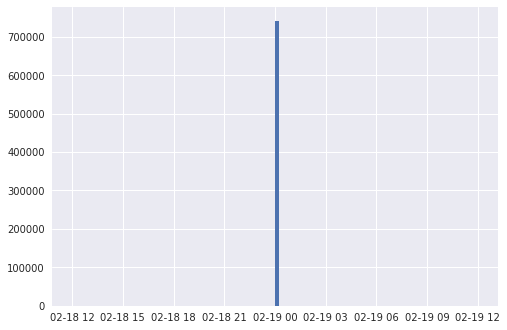

In [8]:
snapshot_dt = test_df.sample_date.max()
print(snapshot_dt)

test_df_ = test_df[test_df.sample_date == snapshot_dt]
print("----- shape -----")
print(test_df_.shape)
print("----- target counts -----")
print(test_df_.target.value_counts())
print("----- ind counts -----")
print(test_df_.indeterminate.value_counts())
print("----- sample_date -----")
print(test_df_.sample_date.hist(bins=100))

In [9]:
print("data imbalance: ", 1/test_df_.target.value_counts(normalize=True).iloc[1])

data imbalance:  406.71334431630976


#### On Active Snapshots
---

In [10]:
test_df_.is_active.value_counts(), test_df_.is_active.value_counts(normalize=True)

(False    559018
 True     181607
 Name: is_active, dtype: int64,
 False    0.754792
 True     0.245208
 Name: is_active, dtype: float64)

----- data size -----
(181607, 103)
----- performance report -----
                     auc     ap     ks
prev_score         93.76  35.62  72.17
refit_score        80.15   2.56  48.64
refit_w_ind_score  96.25  56.13  79.88
----- performance plots -----


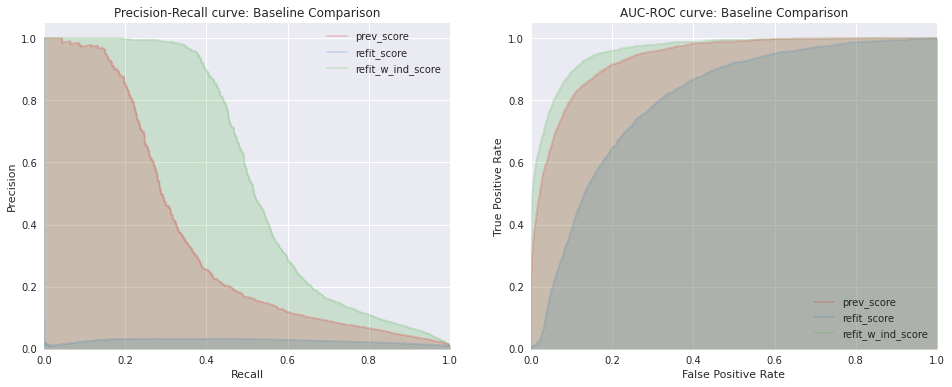

In [11]:
df_ = test_df_[test_df_.is_active]
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols, "./artifacts", dropna=False
)

#### On Full Population
---

----- data size -----
(740625, 103)
----- performance report -----
                     auc     ap     ks
prev_score         78.29  23.92  38.43
refit_score        40.94   0.20   7.42
refit_w_ind_score  97.07  49.85  85.23
----- performance plots -----


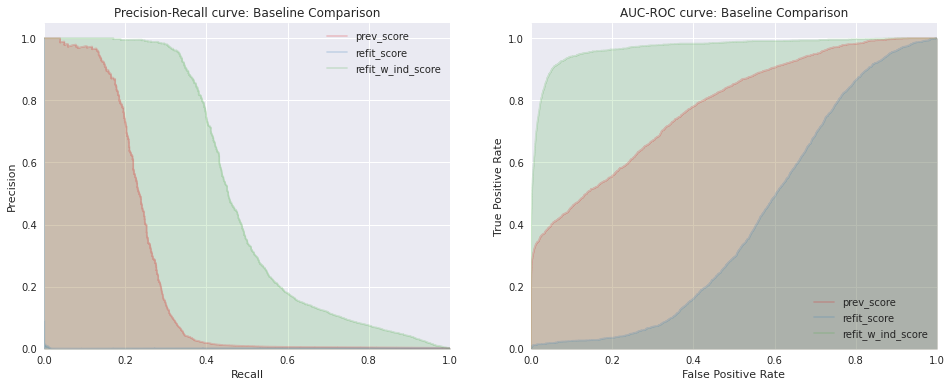

In [12]:
df_ = test_df_
print("----- data size -----")
print(df_.shape)

print("----- performance report -----")
report = mntr.get_pred_reports(test_df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_full": test_df_}, "target", pred_cols, "./artifacts", dropna=False
)

Refitted model has a significantly lower performance

## 11/01/2020
----

2020-11-01 00:00:00
----- shape -----
(503062, 103)
----- target counts -----
False    498440
True       4622
Name: target, dtype: int64
----- ind counts -----
True     398891
False    104171
Name: indeterminate, dtype: int64
----- sample_date -----
AxesSubplot(0.125,0.125;0.775x0.755)


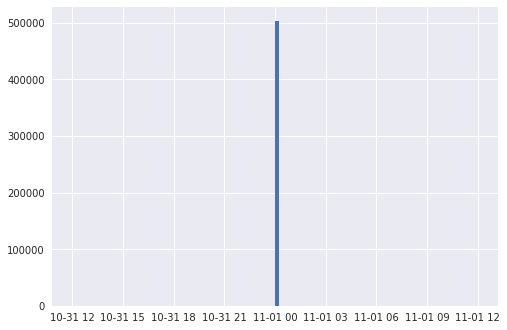

In [13]:
snapshot_dt = pd.to_datetime("2020-11-01")
print(snapshot_dt)

test_df_ = test_df[test_df.sample_date == snapshot_dt]
print("----- shape -----")
print(test_df_.shape)
print("----- target counts -----")
print(test_df_.target.value_counts())
print("----- ind counts -----")
print(test_df_.indeterminate.value_counts())
print("----- sample_date -----")
print(test_df_.sample_date.hist(bins=100))

#### On Active Snapshots
---

In [14]:
test_df_.is_active.value_counts(), test_df_.is_active.value_counts(normalize=True)

(False    364665
 True     138397
 Name: is_active, dtype: int64,
 False    0.724891
 True     0.275109
 Name: is_active, dtype: float64)

----- performance report -----
                     auc     ap     ks
prev_score         87.23  24.99  57.47
refit_score        77.97  10.20  42.31
refit_w_ind_score  88.68  36.54  57.73
----- performance plots -----


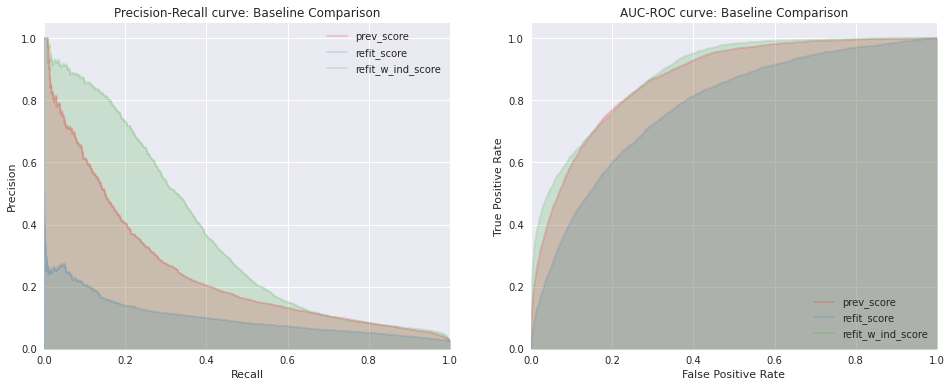

In [15]:
df_ = test_df_[test_df_.is_active]

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols, "./artifacts", dropna=False
)

#### On Full Population
---

----- performance report -----
                     auc     ap     ks
prev_score         73.04  15.19  29.61
refit_score        52.56   1.66   6.90
refit_w_ind_score  90.30  35.68  64.09
----- performance plots -----


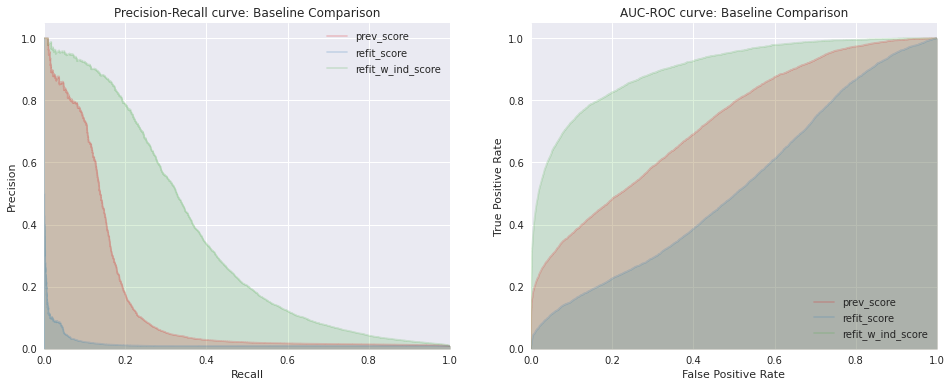

In [16]:
df_ = test_df_

print("----- performance report -----")
report = mntr.get_pred_reports(test_df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_full": test_df_}, "target", pred_cols, "./artifacts", dropna=False
)

Refitted model has a significantly lower performance

### Best Model vs. Benchmarks on 11/01/2021
---

2020-11-01 00:00:00
----- shape -----
(503062, 103)
----- target counts -----
False    498440
True       4622
Name: target, dtype: int64
----- ind counts -----
True     398891
False    104171
Name: indeterminate, dtype: int64
----- sample_date -----
AxesSubplot(0.125,0.125;0.775x0.755)


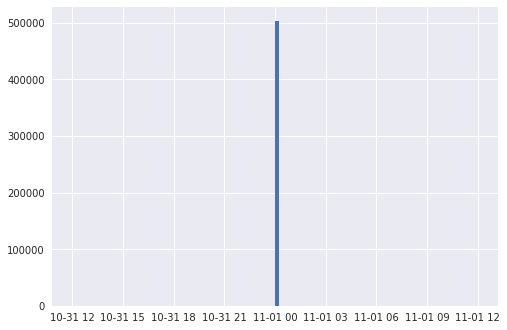

In [17]:
snapshot_dt = pd.to_datetime("2020-11-01")
print(snapshot_dt)

test_df_ = test_df[test_df.sample_date == snapshot_dt]
print("----- shape -----")
print(test_df_.shape)
print("----- target counts -----")
print(test_df_.target.value_counts())
print("----- ind counts -----")
print(test_df_.indeterminate.value_counts())
print("----- sample_date -----")
print(test_df_.sample_date.hist(bins=100))

In [18]:
test_df_.indeterminate.value_counts()

True     398891
False    104171
Name: indeterminate, dtype: int64

In [19]:
print(test_df_.fico_adjusted_pred.isna().value_counts())
print(test_df_.fraud_score_2.isna().value_counts())

False    474983
True      28079
Name: fico_adjusted_pred, dtype: int64
False    488741
True      14321
Name: fraud_score_2, dtype: int64


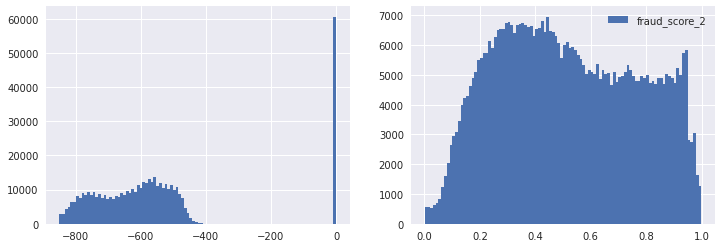

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
test_df_.fico_adjusted_pred.hist(bins=100, ax=axs[0], label="fico_adjusted")
test_df_.fraud_score_2.hist(bins=100, ax=axs[1], label="fraud_score_2")
plt.legend()

In [21]:
test_df_pred_filled_na = test_df_.copy()
test_df_pred_filled_na.loc[test_df_pred_filled_na.fico_adjusted_pred.isna(),
                           "fico_adjusted_pred"] = test_df_pred_filled_na["fico_adjusted_pred"].max()
test_df_pred_filled_na.loc[test_df_pred_filled_na.fraud_score_2.isna(),
                           "fraud_score_2"] = test_df_pred_filled_na["fraud_score_2"].max()

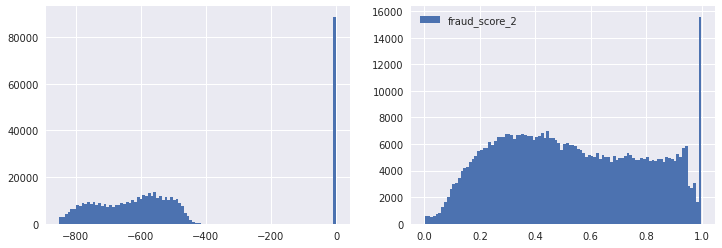

In [22]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
test_df_pred_filled_na.fico_adjusted_pred.hist(bins=100, ax=axs[0], label="fico_adjusted")
test_df_pred_filled_na.fraud_score_2.hist(bins=100, ax=axs[1], label="fraud_score_2")
plt.legend()

#### Active

----- performance report -----
                      auc     ap     ks
fico_adjusted_pred  73.44   4.73  42.30
fraud_score_2       67.85   4.93  28.46
prev_score          87.23  24.99  57.47
refit_w_ind_score   88.68  36.54  57.73
----- performance plots -----


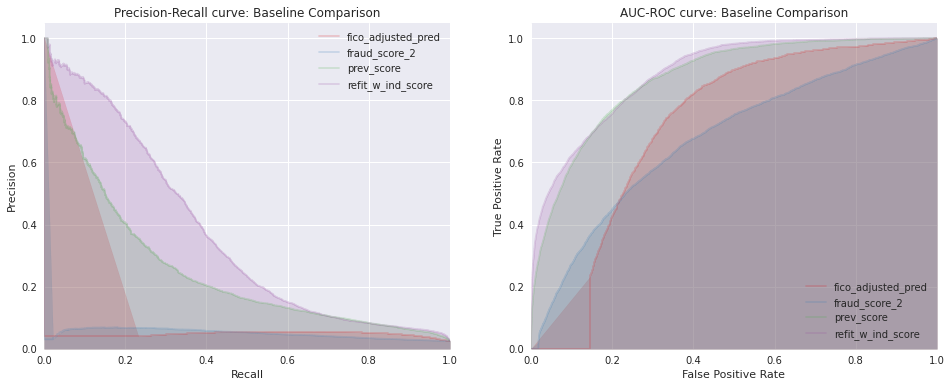

In [23]:
df_ = test_df_pred_filled_na[test_df_pred_filled_na.is_active]
pred_cols_all = ['fico_adjusted_pred', 'fraud_score_2', 'prev_score', 'refit_w_ind_score']

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols_all, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols_all, "./artifacts", dropna=False
)

### Full population

----- performance report -----
                      auc     ap     ks
fico_adjusted_pred  65.30   1.33  27.71
fraud_score_2       63.71   1.47  21.69
prev_score          73.04  15.19  29.61
refit_w_ind_score   90.30  35.68  64.09
----- performance plots -----


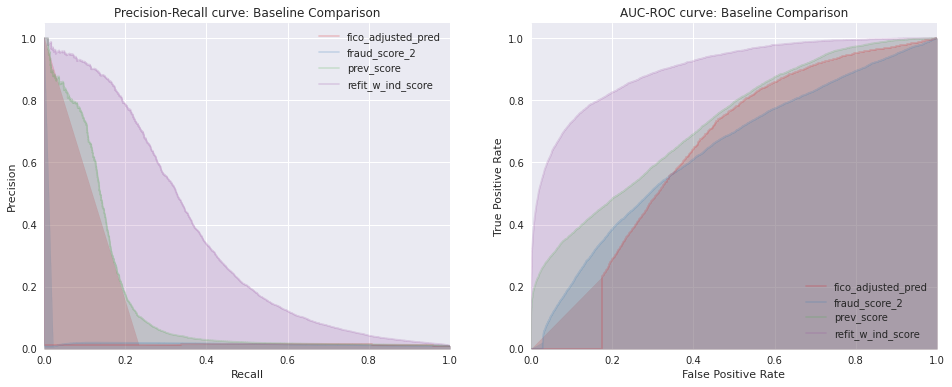

In [24]:
df_ = test_df_pred_filled_na
pred_cols_all = ['fico_adjusted_pred', 'fraud_score_2', 'prev_score', 'refit_w_ind_score']

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols_all, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols_all, "./artifacts", dropna=False
)

#### Okay...filling the score does not look good when interpolating scores
---
Lets just plot performances segmented by whether benchmarks are available..

#### Segment where benchmarks are available

(406716, 103)
----- performance report -----
                      auc     ap     ks
fico_adjusted_pred  69.59   1.63  31.61
fraud_score_2       65.29   2.25  23.48
prev_score          74.04  15.60  31.44
refit_w_ind_score   90.94  36.77  65.85
----- performance plots -----


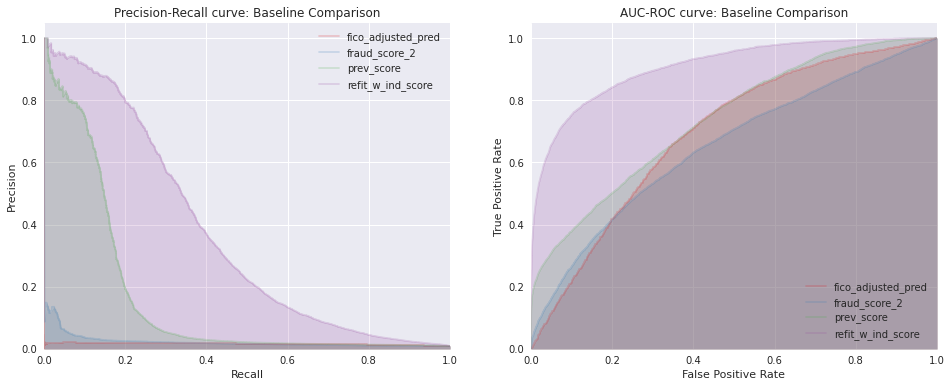

In [25]:
pred_cols_all = ['fico_adjusted_pred', 'fraud_score_2', 'prev_score', 'refit_w_ind_score']
df_ = test_df_[test_df_.fico_score.between(300, 850)
               & test_df_.fraud_score_2.between(0,1)]
print(df_.shape)

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols_all, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols_all, "./artifacts", dropna=False
)

#### When one pred is not available

(96346, 103)
----- fico valid counts -----
valid_fico  valid_sigma
False       True           82025
True        False           7627
False       False           6694
dtype: int64
----- performance report -----
                     auc     ap     ks
prev_score         67.14  14.56  24.90
refit_w_ind_score  87.10  32.33  57.04
----- performance plots -----


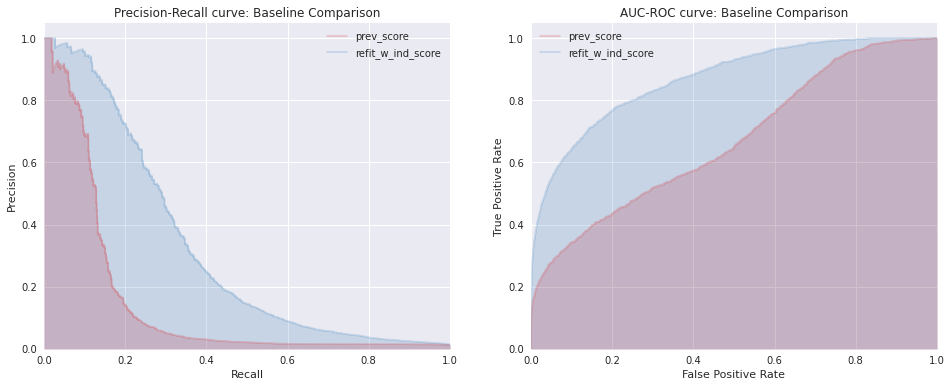

In [26]:
pred_cols = ['prev_score', 'refit_w_ind_score']

df_ = test_df_[~(test_df_.fico_score.between(300, 850)
               & test_df_.fraud_score_2.between(0,1))]
print(df_.shape)
df_["valid_fico"] = df_.fico_score.between(300,850)
df_["valid_sigma"] = df_.fraud_score_2.between(0,1)
print("----- fico valid counts -----")
df_stats = df_[["valid_fico", "valid_sigma"]].value_counts()
print(df_stats)

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols, "./artifacts", dropna=False
)

### Since we have way more sigma score than fico, lets look at sigma vs. model

(488741, 103)
----- fico valid counts -----
valid_fico  valid_sigma
True        True           406716
False       True            82025
dtype: int64
----- performance report -----
                     auc     ap     ks
fraud_score_2      64.85   2.24  22.74
prev_score         72.91  15.59  29.02
refit_w_ind_score  90.35  36.14  64.34
----- performance plots -----


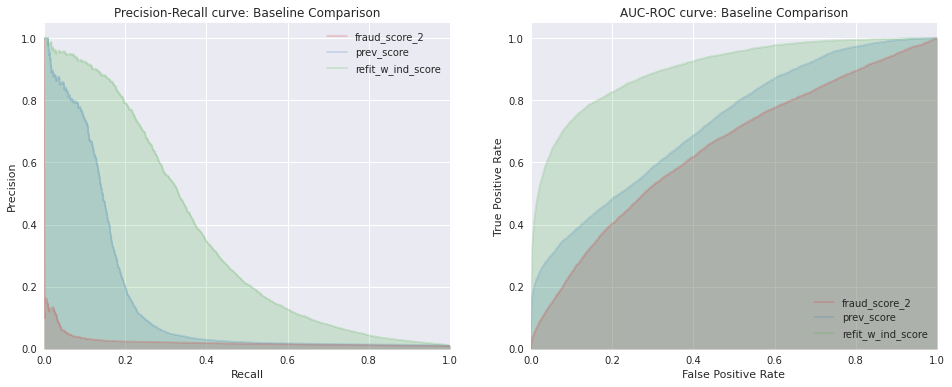

In [27]:
pred_cols = ['fraud_score_2', 'prev_score', 'refit_w_ind_score']

df_ = test_df_[test_df_.fraud_score_2.between(0,1)]
print(df_.shape)
df_["valid_fico"] = df_.fico_score.between(300,850)
df_["valid_sigma"] = df_.fraud_score_2.between(0,1)
print("----- fico valid counts -----")
df_stats = df_[["valid_fico", "valid_sigma"]].value_counts()
print(df_stats)

print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
print(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"prev_vs_refit_active": df_}, "target", pred_cols, "./artifacts", dropna=False
)

#### Look at how many inderminates we have between 11/01/2020 and 20200101
---

In [28]:
modeling_df = pd.read_parquet(modeling_data_path)
modeling_df.indeterminate.value_counts(normalize=True)

False    0.604291
True     0.395709
Name: indeterminate, dtype: float64

In [29]:
prev_mdf = pd.read_feather("s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/dev_data/modeling_df_replication_for_governance.feather")
prev_mdf.indeterminate.value_counts(normalize=True)

False    0.950024
True     0.049976
Name: indeterminate, dtype: float64

<AxesSubplot:>

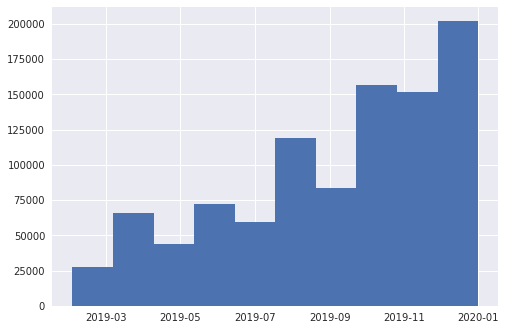

In [30]:
prev_mdf.sample_date.hist()

We have way more indeterminate populations now, which constributed to degration in model performance when trained without indeterminant. 5% -> 40%, an 8 time shift! for TRAINING DATA

#### Indeterminant statistics on static snapshots.

<AxesSubplot:>

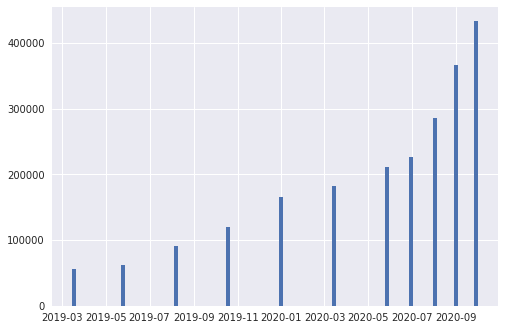

In [28]:
modeling_df = pd.read_parquet(modeling_data_path)
modeling_df = modeling_df[modeling_df.is_static]
modeling_df.sample_date.hist(bins=100)

In [29]:
modeling_df.sample_date.unique()

array(['2019-03-15T00:00:00.000000000', '2019-05-27T00:00:00.000000000',
       '2019-08-08T00:00:00.000000000', '2019-10-20T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-03-14T00:00:00.000000000',
       '2020-05-26T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
df_tmp = modeling_df[modeling_df.sample_date == pd.to_datetime("2020-01-01")]
print(df_tmp.shape)
df_tmp.indeterminate.value_counts(normalize=True).sort_index()

(165763, 91)


False    0.367639
True     0.632361
Name: indeterminate, dtype: float64

In [35]:
df_tmp = test_df[test_df.sample_date == pd.to_datetime("2020-11-01")]
print(df_tmp.shape)
df_tmp.indeterminate.value_counts(normalize=True).sort_index()

(503062, 103)


False    0.207074
True     0.792926
Name: indeterminate, dtype: float64

For snapshot data at a given time, it went from 63.2% -> 79.3% ...

### How will the score of the users shift by switching to the new model
---

2020-11-01 00:00:00
----- shape -----
(503062, 103)
----- target counts -----
False    498440
True       4622
Name: target, dtype: int64
----- ind counts -----
True     398891
False    104171
Name: indeterminate, dtype: int64
----- sample_date -----
AxesSubplot(0.125,0.125;0.775x0.755)


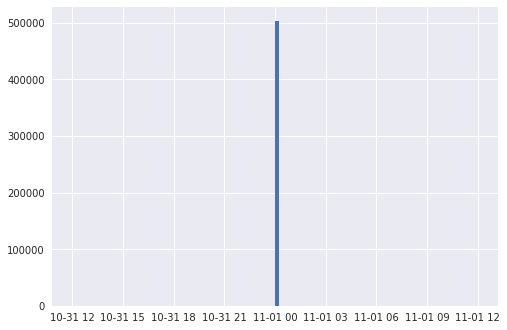

In [13]:
snapshot_dt = pd.to_datetime("2020-11-01")
print(snapshot_dt)

test_df_ = test_df[test_df.sample_date == snapshot_dt]
print("----- shape -----")
print(test_df_.shape)
print("----- target counts -----")
print(test_df_.target.value_counts())
print("----- ind counts -----")
print(test_df_.indeterminate.value_counts())
print("----- sample_date -----")
print(test_df_.sample_date.hist(bins=100))

In [14]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

test_df_['prev_rg'] = get_risk_groups(test_df_.prev_score)
test_df_['refit_rg'] = get_risk_groups(test_df_.refit_score)
test_df_['refit_rg_w_ind'] = get_risk_groups(test_df_.refit_w_ind_score)

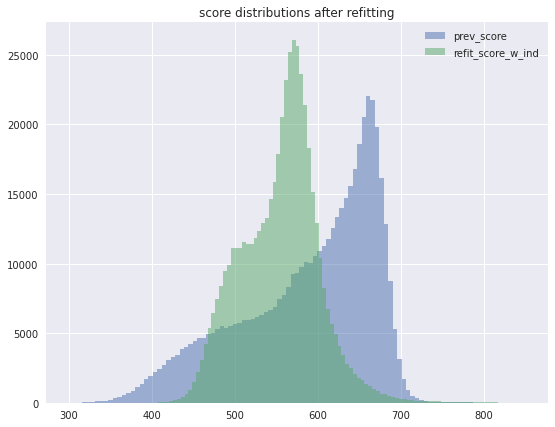

In [17]:
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
_ = plot_score_dist(test_df_.prev_score, test_df_.refit_w_ind_score,
                    dev_label="prev_score", prod_label="refit_score_w_ind", 
                    bins=100, title="score distributions after refitting")

Accounts are being pushed to the center, as the model is getting conservative. One potential reason is because we are refitting with way more data now, so the original model was too small for our use.

How much data in dev data and how much in the refit data?
* for snapshots: 61131 on 12/31/2019 vs. 740k in 2/19/2021
* for sampled dataset: 1.1 Mil vs. 4.2 Mil 

Text(0.5, 1.0, 'Risk Group Shift')

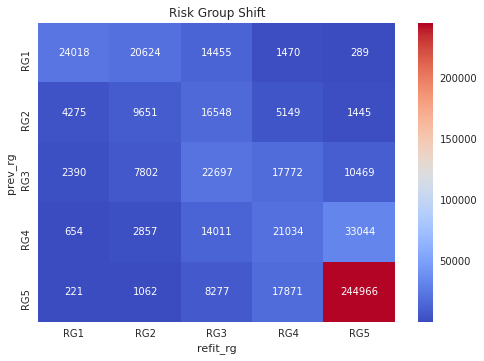

In [33]:
# compare the flow of risk groups - refit_rg
table = test_df_[['prev_rg', 'refit_rg']].value_counts().sort_index().reset_index()
table.columns = ['prev_rg', 'refit_rg', 'counts']
table = pd.pivot_table(table, values='counts', index='prev_rg', 
                       columns='refit_rg', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift')

Text(0.5, 1.0, 'Risk Group Shift')

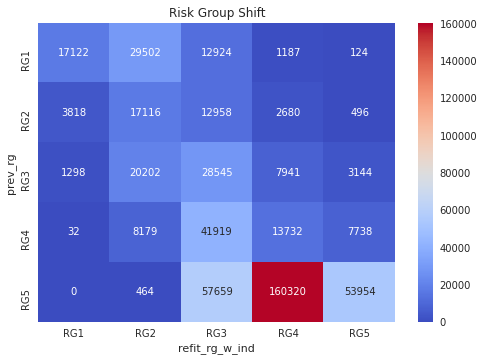

In [34]:
# compare the flow of risk groups - refit_rg
table = test_df_[['prev_rg', 'refit_rg_w_ind']].value_counts().sort_index().reset_index()
table.columns = ['prev_rg', 'refit_rg_w_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='prev_rg', 
                       columns='refit_rg_w_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift')

Text(0.5, 1.0, 'Risk Group distributions')

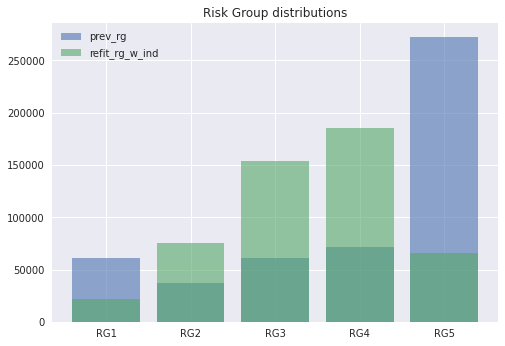

In [35]:
fig = plt.figure()
data = test_df_.prev_rg.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='prev_rg')
data = test_df_.refit_rg_w_ind.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='refit_rg_w_ind')
plt.legend()
plt.title('Risk Group distributions')

We are seeing more rg moving to the center...can be tricky

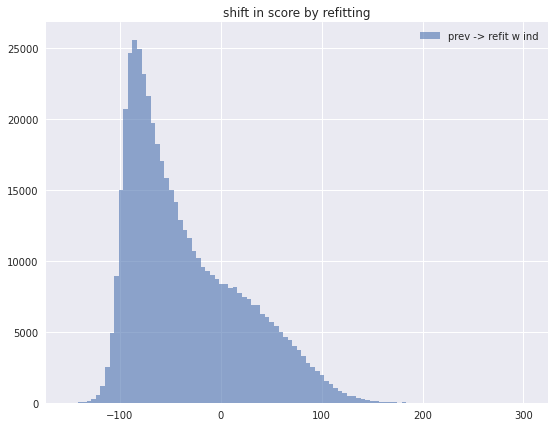

In [36]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difrepeatrence of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

_ = plot_difference(test_df_.refit_w_ind_score, test_df_.prev_score,  
                    bins=100, label="prev -> refit w ind",
                    title="shift in score by refitting")


Scores mostly went up after refitting

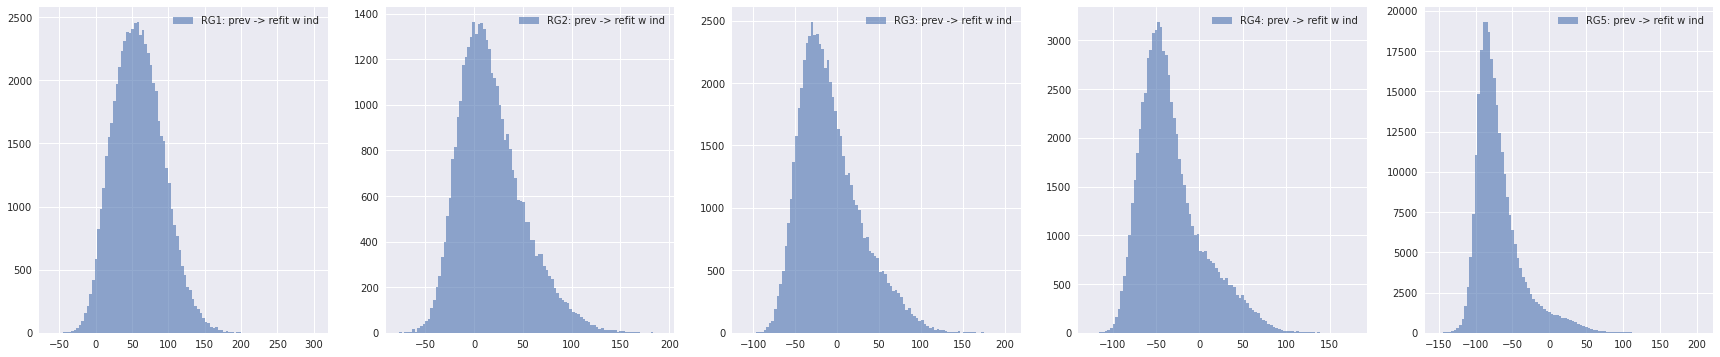

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, rg in enumerate(["RG1", "RG2", "RG3", "RG4", "RG5"]):
    refit_score_w_ind = test_df_[test_df_.prev_rg==rg].refit_w_ind_score
    prev_score = test_df_[test_df_.prev_rg==rg].prev_score
    seq = np.array(refit_score_w_ind) - np.array(prev_score)
    axs[i].hist(seq, alpha=0.6, bins=100, label=f'{rg}: prev -> refit w ind')
    axs[i].legend()